In [275]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import spatial
from sklearn.cross_validation import cross_val_score, KFold
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform 
import utm
from numpy.linalg import inv
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import simplekml

In [116]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [94]:
trn_data = np.genfromtxt('Data_problem3/trn_data.csv', delimiter=',', skip_header=1)
tst_data = np.genfromtxt('Data_problem3/tst_locations.csv', delimiter=',', skip_header=1)

In [215]:
class GP_RainFall:

    def __init__(self,trn_data,tst_data,h): 
        # h is distance between x and x' (bandwidth)
        self.X_trn_raw, self.Y_trn_raw = trn_data[:,:-1], trn_data[:,-1:]
        self.X_tst_raw = tst_data
        self.h = h
        self.K_tsttst = self.covariance(self.ConvertUnit(self.X_tst_raw),self.ConvertUnit(self.X_tst_raw))
        self.K_trntst = self.covariance(self.ConvertUnit(self.X_trn_raw),self.ConvertUnit(self.X_tst_raw))
        self.K_tsttrn = self.covariance(self.ConvertUnit(self.X_tst_raw),self.ConvertUnit(self.X_trn_raw))
        self.K_trntrn = self.covariance(self.ConvertUnit(self.X_trn_raw),self.ConvertUnit(self.X_trn_raw))
        self.I = np.identity(self.K_trntrn.shape[0])
        

    def ConvertUnit(self,array):
        array_list = []
        for n in array:
            meters = utm.from_latlon(n[0],n[1])
            array_list.append(np.array([meters[0], meters[1]]))
        converted_array = np.vstack(array_list)
        return converted_array
        
    #Computing Gaussian covariance:
    def covariance(self, X, Z):
        d = spatial.distance_matrix(X,Z) 
        K = np.exp(-(d**2) / (2*self.h*self.h)) 
        return K

    # Make Predictions
    # predicted mean: m(f)=K(xtest,x)[K+σ^2I−1]^(-1)y
    # cov(f)=K(xtest,xtest)−K(xtest,x)[K+σ2I]^(−1)K(x,xtest)

    def predict(self, sigma, X_trn_raw, X_tst_raw, Y_trn_pre):
        X_tst = self.ConvertUnit(X_tst_raw)
        X_trn = self.ConvertUnit(X_trn_raw)
        
        K_tsttrn = self.covariance(X_tst,X_trn)
        K_trntrn = self.covariance(X_trn,X_trn)
        
        I = np.identity(K_trntrn.shape[0])
        
        mean = np.mean(Y_trn_pre)
        Y_trn = Y_trn_pre - mean*np.ones(Y_trn_pre.shape)
        
        pred_mean = np.dot(np.dot(K_tsttrn,inv(K_trntrn + sigma**2*I)),Y_trn)
        pred_Y = pred_mean + mean*np.ones(pred_mean.shape) # Re-add the mu to get the accurate value
        
        return pred_Y
    
    def predict_cv(self, k, sigma):
        kf = KFold(len(data), n_folds = k, shuffle=True)
        RMSE = []
        for train_index, test_index in kf:
            X_trn_cv, X_tst_cv = self.X_trn_raw[train_index], self.X_trn_raw[test_index]
            Y_trn_cv, Y_tst_cv = self.Y_trn_raw[train_index], self.Y_trn_raw[test_index]
            Y_pred = self.predict(sigma, X_trn_cv, X_tst_cv, Y_trn_cv)
            Y_true = Y_tst_cv
            error = sqrt(mean_squared_error(Y_pred, Y_true))
            RMSE.append(error)
        
        self.RMSE = np.mean(RMSE)
        return self.RMSE
    
    def simulation(self, sigma):
        m_f = self.predict(sigma, self.X_trn_raw, self.X_tst_raw, self.Y_trn_raw) # Get m(f), K_tsttrn, K_trntrn and I

        cov = self.K_tsttst - np.dot(np.dot(self.K_tsttrn,
                            inv(self.K_trntrn + sigma**2*self.I)), self.K_trntst)
        L = np.linalg.cholesky(cov + 0.001*np.eye(cov.shape[0])) #gamma~0.001
        u = np.random.normal(0,1,cov.shape[0])
        f_sim = m_f.reshape(-1,) + np.dot(L,u)
        return f_sim, cov

In [207]:
RMSE1 = []
RMSE2 = []

bandwidth = [x*1000 for x in range(40,90,5)][1:]
sigma = 0.45
k = 5
for h in bandwidth:
    GP = GP_RainFall(trn_data, tst_data, h)
    RMSE1.append(GP.predict_cv(5, sigma))

h = 70000
sigmas = [x for x in frange(0.05, 0.8, 0.05)][1:]
for sigma in sigmas:
    GP = GP_RainFall(trn_data, tst_data, h)
    RMSE2.append(GP.predict_cv(5, sigma))

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(16, 8)

ax1.plot(bandwidth, RMSE1, color='black', linewidth = 2)
ax2.plot(sigmas, RMSE2, color='black', linewidth =2)
 
ax1.set_xlabel('Bandwidth (km)')
ax1.set_ylabel('RMSE')
ax1.set_xticklabels([str(int(x/1000)) for x in bandwidth])
ax2.set_xlabel('Sigma')
plt.savefig('Visual.png')

In [202]:
# predict
h = 70000
sigma = 0.4
df = pd.DataFrame(GP.predict(sigma, trn_data[:,:-1], tst_data, trn_data[:,-1:]), columns =['mm'])
df['id'] = pd.Series([x for x in range(1, 414)])
df = df[['id','mm']]
df.to_csv('predictions_YG.csv', index=False)

In [285]:
# simulation
tst_data = np.genfromtxt('Data_problem3/grid.csv', delimiter=',', skip_header=0)
h = 70000
sigma = 0.4
GP = GP_RainFall(trn_data, tst_data, h)
Y_sim = GP.simulation(sigma)

### Save the simulation result for visualization
output=pd.DataFrame(tst_data,columns=[['lng','lat']])
output['pred'] = pd.Series(Y_sim[0])

#output.to_csv('simulation.csv', index=False)

In [246]:
def make_grid(bounding_box, ncell):
    
    xmax, xmin, ymax, ymin = bounding_box 
    xgrid = np.linspace(xmin, xmax, ncell) 
    ygrid = np.linspace(ymin, ymax, ncell)
    
    mX, mY = np.meshgrid(xgrid, ygrid) 
    ngridX = mX.reshape(ncell*ncell, 1)
    ngridY = mY.reshape(ncell*ncell, 1)
    
    return np.concatenate((ngridX, ngridY), axis=1)

bounding_box = [38.5, 39.3, -119.8, -120.8] 
Xgrid = make_grid(bounding_box, 50)

In [323]:
output = output.sort(['lat', 'lng'], ascending=[0, 1])
output.reset_index(drop=True, inplace=True)

/Users/yiyange/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



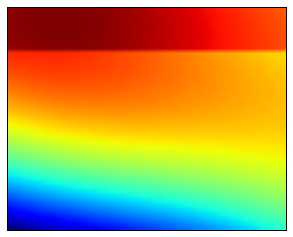

In [325]:
matrix = output[['pred']].as_matrix(columns=None).reshape((50,50))
extent = [-120.8, -119.8,38.5, 39.3]
plt.imshow(matrix, extent=extent)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
#plt.savefig('Heatmap.png',bbox_inches='tight',pad_inches = 0)

In [306]:
kml = simplekml.Kml()
ground = kml.newgroundoverlay(name='GroundOverlay')
# Put the png file into the same folder
ground.icon.href = 'Heatmap.png' 
ground.lookat = simplekml.LookAt(gxaltitudemode=simplekml.GxAltitudeMode.relativetoseafloor,
                                latitude=38.9, longitude=-120.3, range=120000, tilt=70)
ground.latlonbox.north = 39.3
ground.latlonbox.south = 38.5
ground.latlonbox.east =  -120.8
ground.latlonbox.west =  -119.8
ground.latlonbox.rotation = 0
kml.save("Visualization.kml")

In [ ]:
# visualization